<a href="https://colab.research.google.com/github/149189/Sentiment-Analysis-on-IMDb-Reviews/blob/main/Sentiment_Analysis_on_IMDb_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
pip install tensorflow transformers datasets


In [30]:
pip install --upgrade tensorflow transformers


In [31]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from datasets import load_dataset

In [32]:
dataset = load_dataset("imdb")

In [20]:
def get_reviews_by_label(dataset, label):
    return [review['text'] for review in dataset if review['label'] == label]

train_positive_reviews = get_reviews_by_label(dataset['train'], 1)
train_negative_reviews = get_reviews_by_label(dataset['train'], 0)
test_positive_reviews = get_reviews_by_label(dataset['test'], 1)
test_negative_reviews = get_reviews_by_label(dataset['test'], 0)

In [33]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

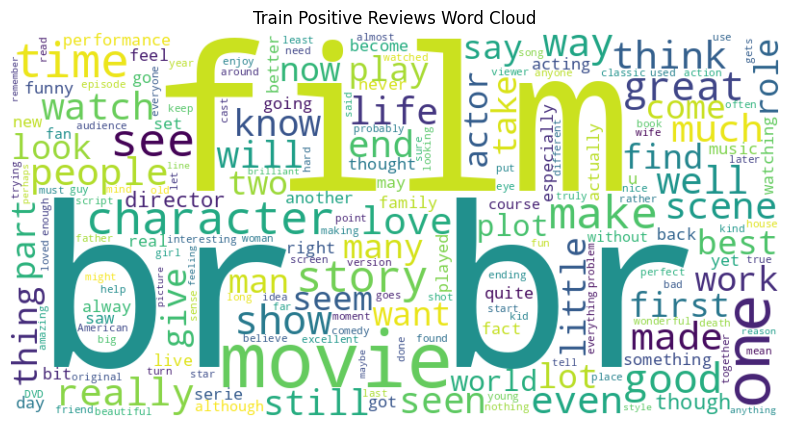

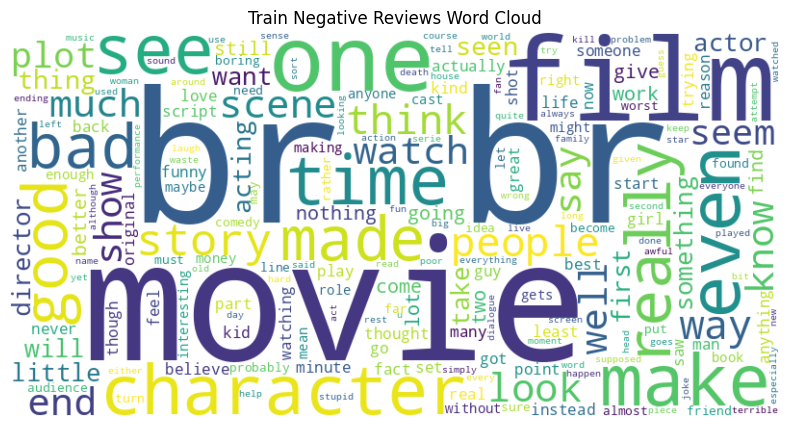

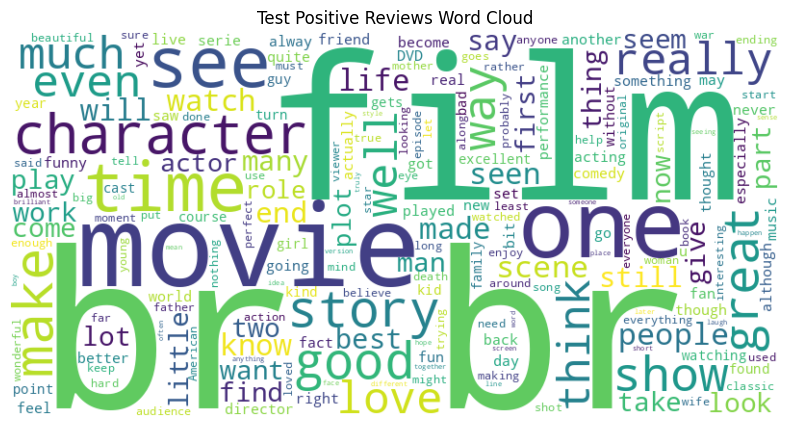

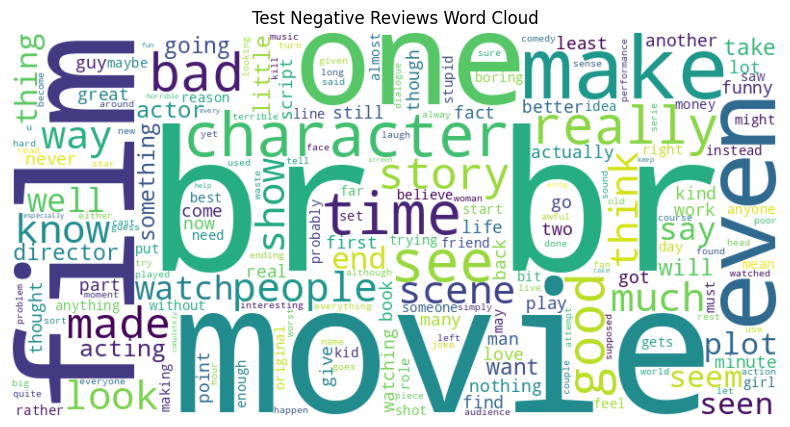

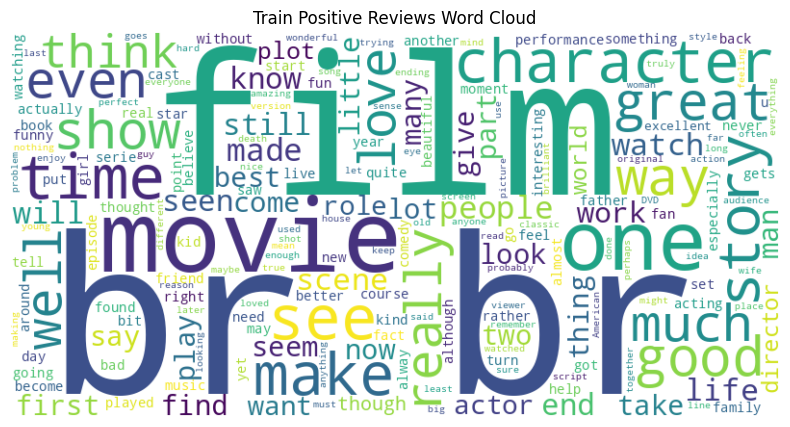

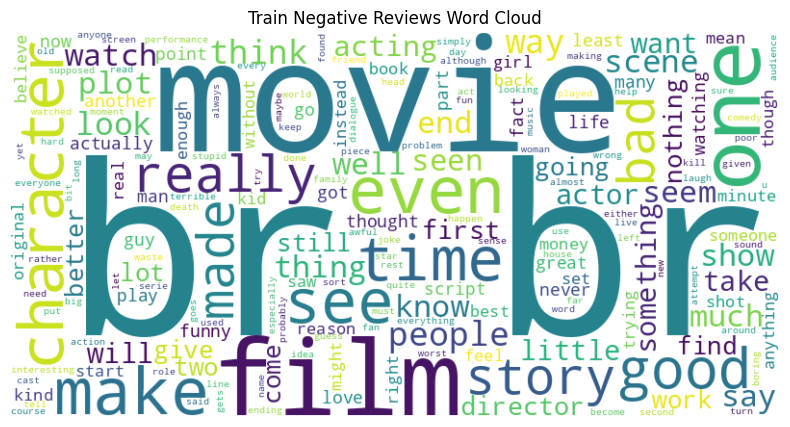

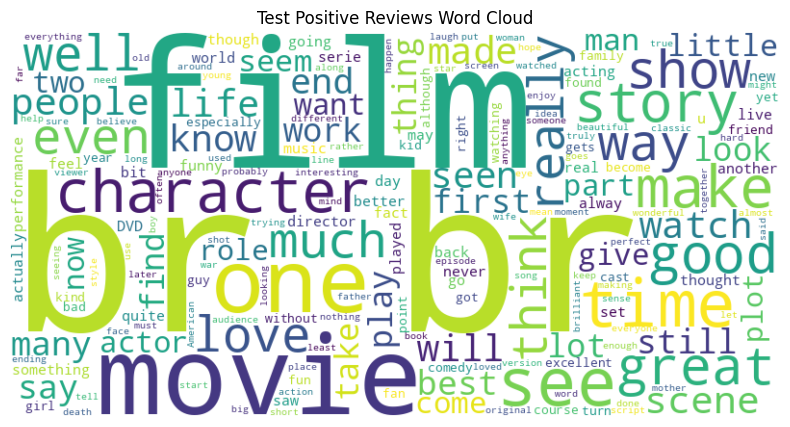

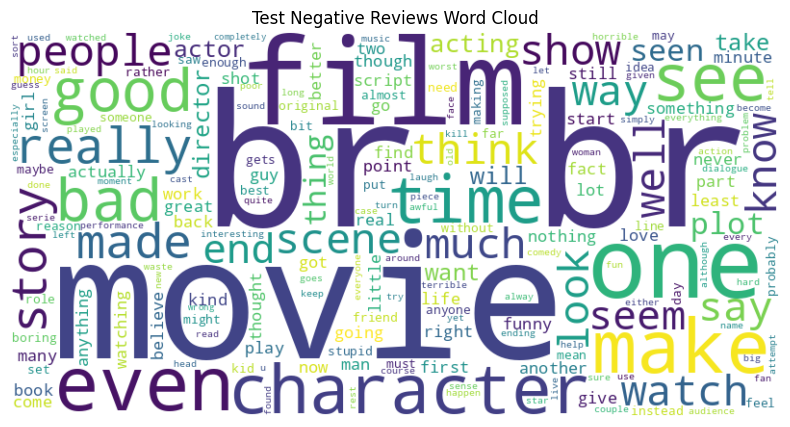

In [34]:
generate_wordcloud(train_positive_reviews, "Train Positive Reviews Word Cloud")
generate_wordcloud(train_negative_reviews, "Train Negative Reviews Word Cloud")
generate_wordcloud(test_positive_reviews, "Test Positive Reviews Word Cloud")
generate_wordcloud(test_negative_reviews, "Test Negative Reviews Word Cloud")

In [35]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
import matplotlib.pyplot as plt

In [36]:
dataset = load_dataset("imdb")
train_dataset = dataset['train']
test_dataset = dataset['test']

In [37]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
def preprocess_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

train_dataset = train_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

In [39]:
train_dataset = train_dataset.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols=["label"],
    shuffle=True,
    batch_size=16
)

test_dataset = test_dataset.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols=["label"],
    shuffle=False,
    batch_size=16
)

In [40]:
optimizer = Adam(learning_rate=3e-5)
loss_fn = SparseCategoricalCrossentropy(from_logits=True)
accuracy_metric = SparseCategoricalAccuracy()

# Lists to store accuracy and loss
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []


In [ ]:
epochs = 3
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    for batch in train_dataset:
        input_ids = batch[0]["input_ids"]
        attention_mask = batch[0]["attention_mask"]
        labels = batch[1]

        with tf.GradientTape() as tape:
            logits = model(input_ids, attention_mask=attention_mask, training=True).logits
            loss = loss_fn(labels, logits)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        epoch_loss_avg.update_state(loss)
        epoch_accuracy.update_state(labels, logits)

Epoch 1/3
Epoch 2/3


In [ ]:
 train_losses.append(epoch_loss_avg.result().numpy())
    train_accuracies.append(epoch_accuracy.result().numpy())
    print(f"Training loss: {train_losses[-1]}, accuracy: {train_accuracies[-1]}")

In [ ]:
val_loss_avg = tf.keras.metrics.Mean()
    val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    for batch in test_dataset:
        input_ids = batch[0]["input_ids"]
        attention_mask = batch[0]["attention_mask"]
        labels = batch[1]

        logits = model(input_ids, attention_mask=attention_mask, training=False).logits
        loss = loss_fn(labels, logits)

        val_loss_avg.update_state(loss)
        val_accuracy.update_state(labels, logits)

In [ ]:
 val_losses.append(val_loss_avg.result().numpy())
    val_accuracies.append(val_accuracy.result().numpy())
    print(f"Validation loss: {val_losses[-1]}, accuracy: {val_accuracies[-1]}")

In [ ]:
epochs_range = range(epochs)

plt.figure(figsize=(14, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()